# Recommender System

This is a recommender system built with collaborative filtering for the movie lens dataset.

# Question 1

In [55]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


def load_data():
    data = pd.read_csv('ml-latest-small/ratings.csv', 
                       names= ['userid', 'movieid', 'rating', 'timestamp'],
                       header=0)
    
    movie_genres = pd.read_csv('ml-latest-small/movies.csv', names=['movieid', 'title', 'genres'], header=0)
    #create R matrix: rows=users, columns=movies
    R = data.pivot_table(index=['userid'], columns=['movieid'], values='rating', fill_value=0).values
    return R, data, movie_genres

R,data, movie_genres = load_data()
print(R.shape)
print(movie_genres.shape)

(671, 9066)
(9125, 3)


In [56]:
#format as surprise data
from surprise import Reader
from surprise import Dataset

reader = Reader(rating_scale=(1.0, 5.0))
data_small = Dataset.load_from_df(data[['userid', 'movieid', 'rating']], reader)


                                      

In [57]:
#Question 1
# total_num_users = 671
# total_num_ratings = 100004
# total_num_movies = 9125 # where did you get this number? get 9066 from R matrix
total_num_users, total_num_movies = R.shape
total_num_ratings = np.count_nonzero(R)

max_possible_ratings = total_num_users * total_num_movies

sparsity = total_num_ratings / max_possible_ratings

print(sparsity) # before 0.01633285017250883

0.016439141608663475


In [58]:
values, counts = np.unique(R, return_counts=True)
dict(zip(values, counts))

mults = values*counts
avg_rating = np.sum(mults)/np.sum(counts[1:])
print(avg_rating)

3.54360825567


# Question 2

Shown below is a plot of the number of ratings for each rating value. In the plot below, the number of sparse (0 entries) is omitted since it dwarfs the other values by more than an order of magnitude. There are 5983282 sparse entries.

Our calculated average rating was 3.544, not including the sparse ratings (0 values). From the graph below, it's clear that this makes sense. Most of the ratings are 4 star, but the lower ratings in the range of 0.5-2.5 bring this average down.

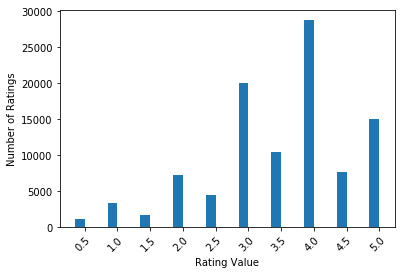

In [61]:
bins = values
ax = plt.subplot(111)
width = 0.3

index = np.arange(len(values[1:]))
ax.bar(index, counts[1:], width=width)

ax.set_xticks(index + width/2)
ax.set_xticklabels(values[1:],rotation=45, rotation_mode="anchor", ha="right")
plt.xlabel("Rating Value")
plt.ylabel("Number of Ratings")

plt.show()

The plot below includes the sparse entries. The second largest category is 4 stars, which has 28750 entries. This is barely visible on the graph.

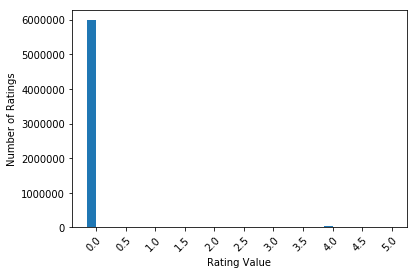

In [62]:
ax = plt.subplot(111)
width = 0.3

index = np.arange(len(values))
ax.bar(index, counts, width=width)

ax.set_xticks(index + width/2)
ax.set_xticklabels(values,rotation=45, rotation_mode="anchor", ha="right")
plt.xlabel("Rating Value")
plt.ylabel("Number of Ratings")


plt.show()

# Question 3
Plotting the distribution of movies. X-axis is the movie index in decreasing frequency and y-axis is the number of ratings the movie has.

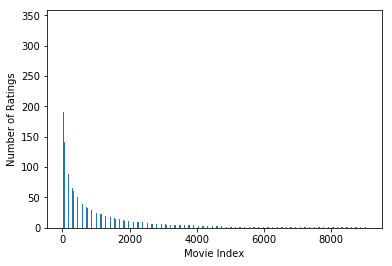

In [63]:
user_row, movie_col = R.shape

distros = [np.count_nonzero(R[:,movie]) for movie in range(movie_col)]
#decorate, sort, undecorate
movie_ids = np.arange(movie_col)
distros, movie_ids = zip(*sorted(zip(distros, movie_ids), reverse=True))

ax = plt.subplot(111)
width = 0.3

index = np.arange(len(movie_ids))
ax.bar(index, distros, width=width)

plt.xlabel("Movie Index")
plt.ylabel("Number of Ratings")
plt.show()

# Question 4
Plotting the distribution of users and their ratings in decreasing frequency. The X-axis is user index sorted by decreasing frequency and the y-axis is the number of movies that user has rated.

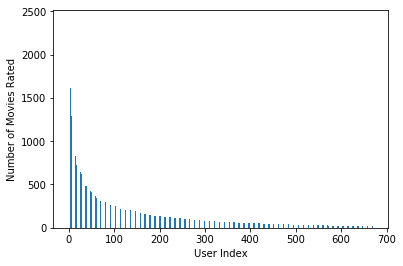

In [64]:
num_ratings_per_user = [np.count_nonzero(R[user,:]) for user in range(user_row)]
user_ids = np.arange(user_row)
num_ratings_per_user, user_ids = zip(*sorted(zip(num_ratings_per_user, user_ids), reverse=True))

ax = plt.subplot(111)
width = 0.3

index = np.arange(len(user_ids))
ax.bar(index, num_ratings_per_user, width=width)
plt.xlabel("User Index")
plt.ylabel("Number of Movies Rated")
plt.show()

# Question 5
Explanation of the salient features of the distribution found in question 3 and implications for recommendation process.

Some movies are much more heavily reviewed than others. Since a user cannot review the same movie twice, we can assume that in the case where a movie has 671 reviews and there are 671 users, each user has reviewed the movie. Therefore, if we know our population size, the number of reviews that a movie has makes it a good indicator of population-wide preference. With collaborative filtering, we want to use commonalities in order to perform interpolation and fill in gaps. Since there is a lot of sparsity in this data, one reduction technique could be to remove movies that fall below a certain threshold of number of reviews. Movies with fewer reviews will cover less of the population spread and be less effective indicators of preference in the collaborative algorithm.

Concretely, question 3's plot shows that one movie had nearly 200 reviews, which spans approximately 29% of the population. Other movies had nearly 150 reviews, or nearly 22% of the population. Thus, these two movies would be excellent choices if we were required to only choose two members of the dataset.

# Question 6
Compute the variance of rating values received by each movie. 

In [311]:
R,data, movie_genres = load_data()

In [52]:
variances = []
for movieid in range(R.shape[1]):
    variances.append(np.var(R[:,movieid]))


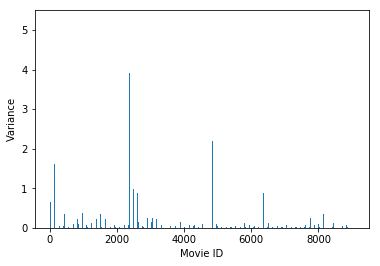

In [65]:
ax = plt.subplot(111)
width = 0.3

index = np.arange(R.shape[1])
ax.bar(index, variances, width=width)

plt.xlabel("Movie ID")
plt.ylabel("Variance")
plt.show()

# Question 7
By summing over $r_{uk}$, we sum up all of the user's ratings. The denominator is the length of the set containing indices for the user's specified ratings. 

\begin{equation}
\frac{\Sigma_{i\in I_{u}} r_{uk}}{|I_{u}|} \forall u \in {1....m}
\end{equation}

# Question 8
$I_{u} \cap I_{v}$ represents the intersection of the two sets of indices for users u and v. Concretely, this intersection is the set containing the indices of items both users rated. It's possible for the intersection to be the empty set $\emptyset$ if two users have not rated any of the same movies. 

For example, let's say two users rate one movie each. User 1 rates Batman and User 2 rates Star Wars. The intersection of indices would be the empty  set ($I_{u} \cap I_{v} = \emptyset$).

# Question 9
We perform mean centering as a form of normalization. Without normalization, the approach would be to define a match/peer group as the set consisting of the k-nearest neighbors given highest Pearson correlation coefficient. However, since we're iterating over items that don't necessarily have the same number of ratings per user, there will be differences from iteration to iteration. If we return the weighted average of the ratings as the predicted rating for an item, an especially sparsely rated value (one rated by a single user) can be skewed if the user is biased. For example, a user may rate every movie with 5 stars. Conversly, a user may rate every movie with 0.5 stars. A biased user such as this would skew a sparse row of ratings and offset the prediction. Mean subtraction is performed in order to minimize the skew these types of users can have on predictions.

# Question 10
Design a k-NN collaborative filter to predict the ratings of the movies in the MovieLens dataset and evaluate it’s performance using 10-fold cross validation. Sweep k ( number of neighbors) from 2 to 100 in step sizes of 2, and for each k compute the average RMSE and average MAE obtained by averaging the RMSE and MAE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis) and average MAE (Y-axis) against k (X-axis).


In [313]:
from surprise import KNNBasic, KNNWithMeans
from surprise import Dataset
from surprise.model_selection import cross_validate

ks = np.linspace(2, 100, num=50)
sim_options = {'name': 'pearson_baseline'}



In [314]:
%%capture
#run the sweeps
outputs = []
for k in ks:
    algo = KNNWithMeans(k=int(k), sim_options=sim_options)
    outputs.append(cross_validate(algo, data_small, measures=['RMSE', 'MAE'], cv=10))
    

In [315]:
avg_rmses = []
avg_maes = []
for output in outputs:
    #average the test_rmse
    avg_rmses.append(np.mean(output['test_rmse']))
    
    #average the test_mae
    avg_maes.append(np.mean(output['test_mae']))

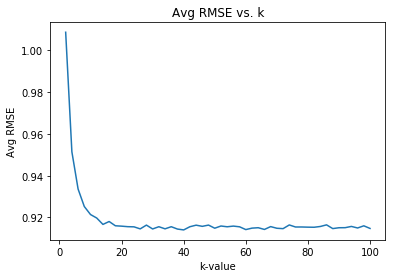

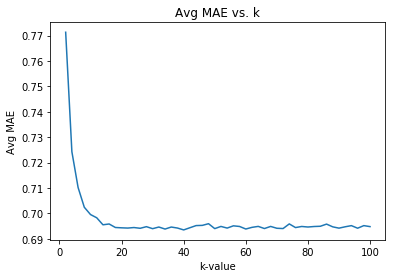

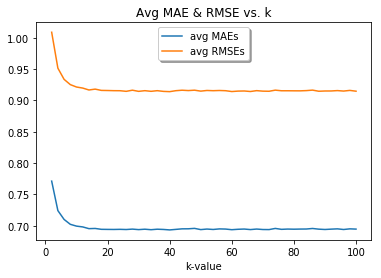

In [316]:
def plotStats(avg_rmses=None, avg_maes=None):
    if avg_rmses is not None:
        ax = plt.subplot(111)
        width = 2

        plt.title("Avg RMSE vs. k")
        plt.ylabel("Avg RMSE")
        plt.xlabel("k-value")
        ax.plot(ks, avg_rmses)
        plt.show()

    if avg_maes is not None:
        ax = plt.subplot(111)
        width = 2

        plt.title("Avg MAE vs. k")
        plt.ylabel("Avg MAE")
        plt.xlabel("k-value")
        ax.plot(ks, avg_maes)
        plt.show()

    if avg_rmses is not None and avg_maes is not None:
        ax = plt.subplot(111)
        width = 2

        plt.title("Avg MAE & RMSE vs. k")
        plt.xlabel("k-value")
        ax.plot(ks, avg_maes, label="avg MAEs")
        ax.plot(ks, avg_rmses, label="avg RMSEs")
        legend = ax.legend(loc='upper center', shadow=True)
        plt.show()

    
plotStats(avg_rmses=avg_rmses, avg_maes=avg_maes)

# Question 11: Find a "Minimum k"
Goal is to find the point at which increasing k does not result in a signficant decrease in average RMSE or average MAE.

In [317]:
import math

def euclidean_elbow(ks, curve, verbose=False):
    #get first point
    s_x, s_y = ks[0], curve[0]

    #get last point
    e_x, e_y = ks[len(ks)-1], curve[len(curve)-1]

   

    slope = (e_y-s_y)/float(e_x-s_x)
    b = s_y - slope*s_x
#    print(s_x, s_y)
#    print(e_x, e_y)
#    print(slope)
    #get midpoint
    m_idx = int((len(ks)/2)-1)
    x_mid = ks[m_idx]
    y_mid = slope*x_mid + b


    #iterate through all points along the curve
    distances = []
    for x, y in zip(ks, curve):
        #get the x and y points of the vector line
        y2 = e_y
        y1 = s_y
        x2 = e_x
        x1 = s_x
        x3 = x
        y3 = y
        
        k = ((y2-y1) * (x3-x1) - (x2-x1) * (y3-y1)) / ((y2-y1)**2 + (x2-x1)**2)
        x4 = x3 - k * (y2-y1)
        y4 = y3 + k * (x2-x1) 
        #calculate distance
        distance = math.sqrt((x-x4)**2 + (y-y4)**2)
        distances.append(distance)

    #find max distance
    max_dist_index = np.argmax(distances)
    if(verbose):
        print(distances)
        print("best k: ", ks[max_dist_index])




    return max_dist_index

In [318]:
mae_idx = euclidean_elbow(ks, avg_maes)
print("Best k for MAE is index: ", mae_idx, "  || best k-value: ", ks[mae_idx])

rmse_idx = euclidean_elbow(ks, avg_rmses)
print("Best k for RMSE is index: ", rmse_idx, " || best k-value: ", ks[rmse_idx])

print("Minimum K = %d" % max(ks[mae_idx], ks[rmse_idx])) # 16

Best k for MAE is index:  6   || best k-value:  14.0
Best k for RMSE is index:  6  || best k-value:  14.0
Minimum K = 14


## Testset trim helper functions

In [27]:
from surprise import KNNBasic, KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import KFold

def getIR(testset):
    o = {}
    for u, i, r in testset:
        if int(i) in o:
            o[int(i)].append((int(u), r))
        else:
            o[int(i)] = [(int(u), r)]
    return o

def buildItemVar(trainset, testsetir):
    o = {}
    for k, v in trainset.ir.items():
        o[k] = [r for u, r in v]
    for k, v in testsetir.items():
        if k in o:
            for u, r in v:
                o[k].append(r)
        else:
            o[k] = [r for u, r in v]
    return o


In [320]:
def popularTrim(trainset, testset, verbose=False):
    '''
    if a movie in the test set has received less than or equal to 2 ratings in the entire
    dataset then we delete that movie from the test set and do not predict the
    rating of that movie using the trained filter.
    '''
    testsetir = getIR(testset)
    removed = 0
    blacklist = {}
    for testKey, testVal in testsetir.items():
        ref = len(testVal) + len(trainset.ir[testKey])
        if ref <= 2:
            removed += 1
            blacklist[testKey] = True
        
    newtestset = []
    for u, i, r in testset:
        if i not in blacklist:
            newtestset.append((u, i, r))
    if(verbose):
        print("popular trimmed %i examples" % removed)
    return newtestset
    
def unpopularTrim(trainset, testset, verbose=False):
    testsetir = getIR(testset)
    removed = 0
    blacklist = {}
    for testKey, testVal in testsetir.items():
        ref = len(testVal) + len(trainset.ir[testKey])
        if ref > 2:
            removed += 1
            blacklist[testKey] = True
        
    newtestset = []
    for u, i, r in testset:
        if i not in blacklist:
            newtestset.append((u, i, r))
    
    if(verbose):
        print("unpopular trimmed %i examples" % removed)
    return newtestset
    
def highVarTrim(trainset, testset, verbose=False): # ties in with question 6
    testsetir = getIR(testset)
    removed = 0
    blacklist = {}
    itemvars = buildItemVar(trainset, testsetir)
    for testKey, testVal in testsetir.items():
        ref = len(testVal) + len(trainset.ir[testKey])
        if ref < 5 or np.var(itemvars[testKey]) < 2:
            removed += 1
            blacklist[testKey] = True
        
    newtestset = []
    for u, i, r in testset:
        if i not in blacklist:
            newtestset.append((u, i, r))
    
    if(verbose):
        print("high var trimmed %i examples" % removed)
    return newtestset

# Question 12: Popular Movie Trimming
In this trimming, we trim the test set to contain movies that has received more than 2 ratings. To be specific, if a movie in the test set has received less than or equal to 2 ratings in the entire dataset then we delete that movie from the test set and do not predict the rating of that movie using the trained filter.

In [324]:
from surprise import KNNBasic, KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import KFold

data = data_small
ks = np.linspace(2, 100, num=50)
kf = KFold(n_splits=10)

In [325]:
%%capture
avgRmses = []
for k in ks:
    print("k-val: ",k)
    algo = KNNWithMeans(k=int(k), sim_options={'name': 'pearson_baseline'})
    
    totalRMSE = 0
    totalMAE = 0
    for trainset, testset in kf.split(data):
        algo.fit(trainset)

        predictions = algo.test(popularTrim(trainset, testset))

        totalRMSE += accuracy.rmse(predictions)
        
    avgRmses.append(totalRMSE / 10.)
    


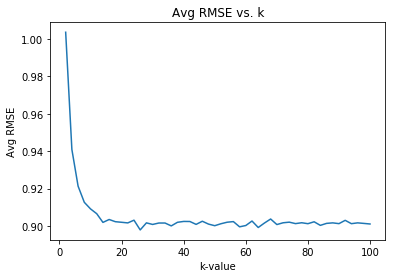

Minimum avg rmse = 0.8979


In [326]:
plotStats(avg_rmses=avgRmses)
print("Minimum avg rmse = %.4f" % np.amin(avgRmses))

# Question 13: Unpopular Movie Trimming

In [327]:
%%capture
avgRmses = []
for k in ks:
    algo = KNNWithMeans(k=int(k), sim_options={'name': 'pearson_baseline'})
    
    totalRMSE = 0
    totalMAE = 0
    for trainset, testset in kf.split(data):
        algo.fit(trainset)

        predictions = algo.test(unpopularTrim(trainset, testset))

        totalRMSE += accuracy.rmse(predictions)
        
    avgRmses.append(totalRMSE / 10.)
    


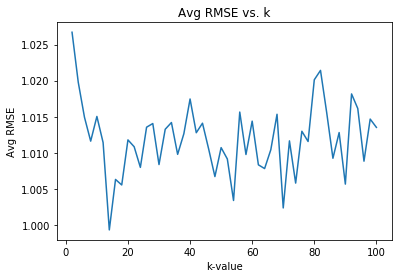

Minimum avg rmse = 0.9993


In [328]:
plotStats(avg_rmses=avgRmses)
print("Minimum avg rmse = %.4f" % np.amin(avgRmses))

# Question 14: High Variance Movie Trimming

In [329]:
%%capture
avgRmses = []
for k in ks:
    algo = KNNWithMeans(k=int(k), sim_options={'name': 'pearson_baseline'})
    
    totalRMSE = 0
    totalMAE = 0
    for trainset, testset in kf.split(data):
        algo.fit(trainset)

        predictions = algo.test(highVarTrim(trainset, testset))

        totalRMSE += accuracy.rmse(predictions)
        
    avgRmses.append(totalRMSE / 10.)

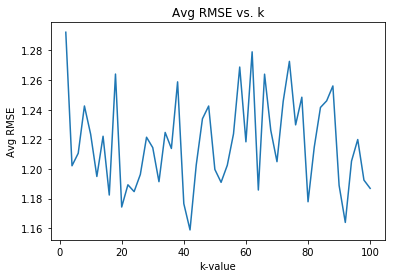

Minimum avg rmse = 1.1588


In [330]:
plotStats(avg_rmses=avgRmses)
print("Minimum avg rmse = %.4f" % np.amin(avgRmses))

# Question 15: 
Plot the ROC curves for the k-NN collaborative filter designed in question 10 for threshold values [2.5, 3, 3.5, 4]. For the ROC plotting use the k found in question 11. For each of the plots, also report the area under the curve (AUC) value.

For the ROC plotting, split the dataset into 90% for training and 10% for
testing

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


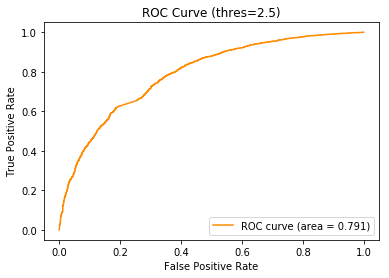

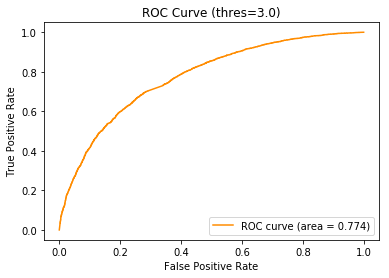

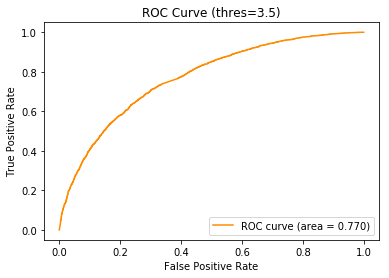

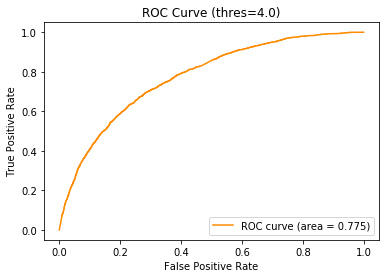

In [355]:
from sklearn import metrics


data = data_small
kf = KFold(n_splits=10) # 90% for training and 10% for testing
trainset, testset = None, None
for train, test in kf.split(data): # just use the first split since we're not cross validating  (are we?)
    trainset, testset = train, test
    break
algo = KNNWithMeans(k=14, sim_options={'name': 'pearson_baseline'})
algo.fit(trainset)
pred = algo.test(testset)

for thres in [2.5, 3, 3.5, 4]:
    y_true, y_pred = [], []
    for u, i, r_real, r_pred, misc in pred:
        y_true.append(thres < r_real)
        y_pred.append(r_pred)

    fpr, tpr, _ = metrics.roc_curve(y_true=y_true, y_score=y_pred, pos_label=1)
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.3f)' % metrics.roc_auc_score(y_true=y_true, y_score=y_pred))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (thres=%.1f)' % thres)
    plt.legend(loc="lower right")
    plt.show()    

# Question 16
## Is the optimization problem given by equation 5 convex? 
Considering U fixed, one can calculate the cost function's Hessian matrix by taking the double derviative with respect to V. This Hessian Matrix is shown to be positive semi-definite. Hence, the optimization problem given by equation 5 is convex.


# Question 17
Design a NNMF-based collaborative filter to predict the ratings of
the movies in the MovieLens dataset and evaluate it’s performance using 10-fold
cross-validation. Sweep k (number of latent factors) from 2 to 50 in step sizes
of 2, and for each k compute the average RMSE and average MAE obtained
by averaging the RMSE and MAE across all 10 folds. Plot the average RMSE (Y-axis) against k (X-axis) and the average MAE (Y-axis) against k (X-axis).
For solving this question, use the default value for the regularization parameter.

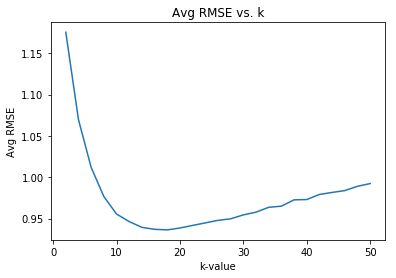

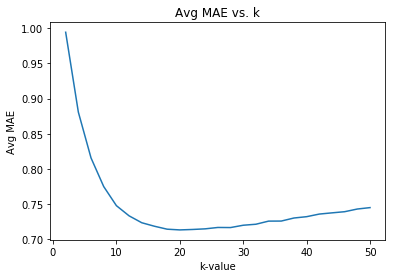

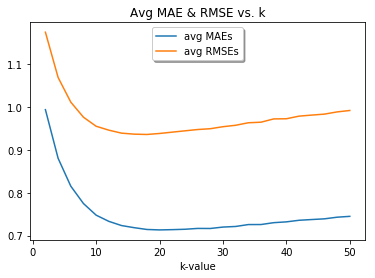

In [332]:
from surprise import NMF

data = data_small
ks = np.linspace(2, 50, num=25)

outputs = []
for k in ks:
    algo = NMF(n_factors=int(k))
    outputs.append(cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=10))
    
avg_rmses = []
avg_maes = []
for output in outputs:
    avg_rmses.append(np.mean(output['test_rmse']))
    avg_maes.append(np.mean(output['test_mae']))
    
plotStats(avg_rmses=avg_rmses, avg_maes=avg_maes)

# Question 18: Find minimum k
Use the plot from question 17, to find the optimal number of
latent factors. Optimal number of latent factors is the value of k that gives
the minimum average RMSE or the minimum average MAE. Please report the
minimum average RMSE and MAE. Is the optimal number of latent factors
same as the number of movie genres?

In [333]:
mae_idx = np.argmin(avg_maes)
print("Best k for MAE is index: ", mae_idx, "  || best k-value: ", ks[mae_idx])

rmse_idx = np.argmin(avg_rmses)
print("Best k for RMSE is index: ", rmse_idx, " || best k-value: ", ks[rmse_idx])

print("Minimum K = %d" % max(ks[mae_idx], ks[rmse_idx])) # 16

Best k for MAE is index:  9   || best k-value:  20.0
Best k for RMSE is index:  8  || best k-value:  18.0
Minimum K = 20


There are 19 genres including "no genre selected". Best best k-value for MAE is 20, and the best k-value for RMSE is 18. This makes sense, since the genres that bring us information are 1-18, and "no genre selected" (the 19th) brings no information.

# Question 19: Popular Trim NNMF

In [334]:
%%capture
from surprise import NMF
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import KFold

data = data_small
ks = np.linspace(2, 50, num=25)
kf = KFold(n_splits=10)

avgRmses = []
for k in ks:
    algo = NMF(n_factors=int(k))
    
    totalRMSE = 0
    totalMAE = 0
    for trainset, testset in kf.split(data):
        algo.fit(trainset)

        predictions = algo.test(popularTrim(trainset, testset))

        totalRMSE += accuracy.rmse(predictions)
        
    avgRmses.append(totalRMSE / 10.)

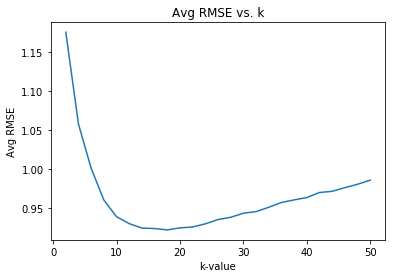

Minimum avg rmse = 0.9221


In [335]:
plotStats(avg_rmses=avgRmses)
print("Minimum avg rmse = %.4f" % np.amin(avgRmses))

# Question 20: Unpopular Trim NNMF

In [336]:
%%capture
data = data_small
ks = np.linspace(2, 50, num=25)
kf = KFold(n_splits=10)

avgRmses = []
for k in ks:
    algo = NMF(n_factors=int(k))
    
    totalRMSE = 0
    totalMAE = 0
    for trainset, testset in kf.split(data):
        algo.fit(trainset)

        predictions = algo.test(unpopularTrim(trainset, testset))

        totalRMSE += accuracy.rmse(predictions)
        
    avgRmses.append(totalRMSE / 10.)

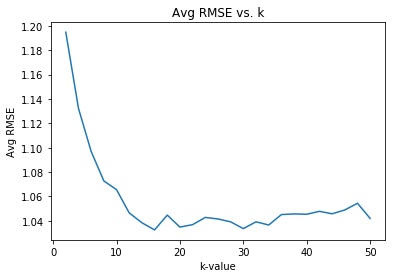

Minimum avg rmse = 1.0324


In [337]:
plotStats(avg_rmses=avgRmses)
print("Minimum avg rmse = %.4f" % np.amin(avgRmses))

# Question 21: High Var Trim NNMF

In [338]:
%%capture
data = data_small
ks = np.linspace(2, 50, num=25)
kf = KFold(n_splits=10)

avgRmses = []
for k in ks:
    algo = NMF(n_factors=int(k))
    
    totalRMSE = 0
    totalMAE = 0
    for trainset, testset in kf.split(data):
        algo.fit(trainset)

        predictions = algo.test(highVarTrim(trainset, testset))

        totalRMSE += accuracy.rmse(predictions)
        
    avgRmses.append(totalRMSE / 10.)

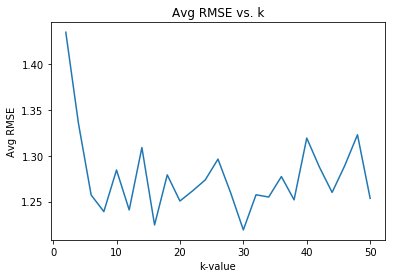

Minimum avg rmse = 1.2192


In [339]:
plotStats(avg_rmses=avgRmses)
print("Minimum avg rmse = %.4f" % np.amin(avgRmses))

# Question 22
Plot the ROC curves for the NNMF-based collaborative filter
designed in question 17 for threshold values [2.5, 3, 3.5, 4]. For the ROC plotting
use the optimal number of latent factors found in question 18. For each of
the plots, also report the area under the curve (AUC) value.

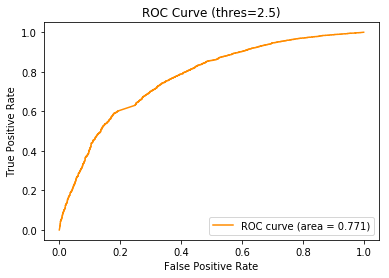

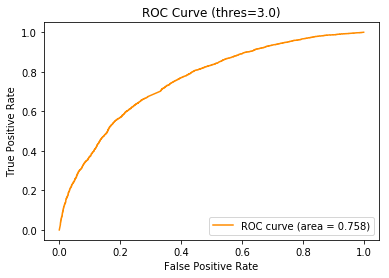

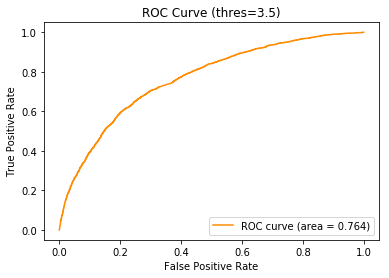

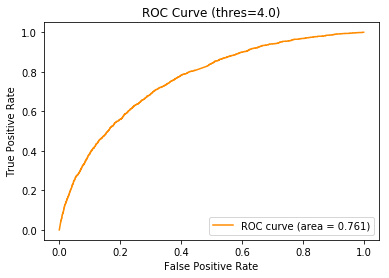

In [358]:
from sklearn import metrics

data = data_small
kf = KFold(n_splits=10) # 90% for training and 10% for testing
trainset, testset = None, None
for train, test in kf.split(data): # just use the first split since we're not cross validating  (are we?)
    trainset, testset = train, test
    break
algo = NMF(n_factors=18)
algo.fit(trainset)
pred = algo.test(testset)

for thres in [2.5, 3, 3.5, 4]:
    fpr, tpr, _ = metrics.roc_curve(y_true=y_true, y_score=y_pred, pos_label=1)
    y_true, y_pred = [], []
    for u, i, r_real, r_pred, misc in pred:
        y_true.append(thres < r_real)
        y_pred.append(r_pred)

    fpr, tpr, _ = metrics.roc_curve(y_true=y_true, y_score=y_pred, pos_label=1)
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.3f)' % metrics.roc_auc_score(y_true=y_true, y_score=y_pred))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (thres=%.1f)' % thres)
    plt.legend(loc="lower right")
    plt.show()

# Question 23
Perform Non-negative matrix factorization on the ratings matrix
R to obtain the factor matrices U and V , where U represents the user-latent
factors interaction and V represents the movie-latent factors interaction (use k
= 20). For each column of V , sort the movies in descending order and report
the genres of the top 10 movies. Do the top 10 movies belong to a particular
or a small collection of genre? Is there a connection between the latent factors
and the movie genres?

In [341]:
from surprise import NMF

nmf = NMF(n_factors=20)
trainset = data_small.build_full_trainset()
nmf.fit(trainset)

In [342]:
#pu = user factors
print(nmf.pu.shape)

#qi = movie (item) factors : V
print(nmf.qi.shape)

#bu = user biases
print(nmf.bu.shape)

#bi = item biases
print(nmf.bi.shape)

(671, 20)
(9066, 20)
(671,)
(9066,)


In [344]:
#first two columns
col1 = nmf.qi[:,0]
# print(col1.shape)
col1_indices = np.linspace(0, 9065, num=9066)

col2 = nmf.qi[:,1]
# print(col2.shape)
col2_indices = np.linspace(0, 9065, num=9066)
#print(col2_indices)

#sort col1 
col1_sorted, col1_indices_sorted = zip(*sorted(zip(col1, col1_indices), reverse=True))
print(col1_sorted[0:9])
print(col1_indices_sorted[0:9])

#assemble movie genres of sorted movies
col1_genres = []
for index in col1_indices_sorted[0:9]:
   col1_genres.append(movie_genres['genres'][index])

print(col1_genres)

print("-----")

#sort col2
col2_sorted, col2_indices_sorted = zip(*sorted(zip(col2, col2_indices), reverse=True))
print(col2_sorted[0:9])
print(col2_indices_sorted[0:9])

#assemble movie genres of sorted movies
col2_genres = []
for index in col2_indices_sorted[0:9]:
   col2_genres.append(movie_genres['genres'][index])

print(col2_genres)

(2.0761242896921175, 1.8613424997694354, 1.8117364366835746, 1.7746877478353953, 1.7174947190675953, 1.6685128206237885, 1.6663994267538271, 1.6221878224335065, 1.5736739950038825)
(5533.0, 2700.0, 2925.0, 6180.0, 6872.0, 2228.0, 5905.0, 1947.0, 5546.0)
['Drama|Thriller', 'Drama|Mystery|Thriller', 'Comedy|Western', 'Comedy|Romance', 'Crime|Drama', 'Horror', 'Drama', 'Comedy|Drama|Thriller', 'Romance|Sci-Fi']
-----
(2.2006743425559887, 2.0485506507025906, 2.0371089354092091, 1.8253593080550075, 1.7774270831181742, 1.6756393480908844, 1.6175872473317292, 1.5759043531185466, 1.5527854847826694)
(4882.0, 6182.0, 6916.0, 6906.0, 1058.0, 4852.0, 6904.0, 3096.0, 3464.0)
['Children|Comedy|Fantasy', 'Action|Sci-Fi|Thriller', 'Action|Crime|Drama|IMAX', 'Drama|War', 'Drama|Romance', 'Crime|Drama|Mystery', 'Drama|Thriller', 'Drama', 'Comedy|Drama']


The top 10 movies in column 1 are primarily comedy, drama, and romance movies. This indicates that the latent feature of column 1 picks up on movies that have a similar mix of genre of comedy, drama and romance. Similarily, for column 2, the top movies seemed to be of comedy, sci-fi, and thriller. Hence, this latent feature groups movies together that have the a mix of comedy, sci-fi, and thriller genres. 

Overall, the latent factors, which are represented in each different column, help our filtering techniques determine a rating of a movie for a given user, as they provide some natural intuition to how similar users might behave e.g. two users will give a high rating to certain movie if the user



# Question 24
 Design a MF with bias collaborative filter to predict the ratings of the movies in the MovieLens dataset and evaluate it’s performance using 10-fold cross-validation. Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE and average MAE obtained by averaging the RMSE and MAE across all 10 folds. Plot the average RMSE (Y-axis) against k (X-axis) and the average MAE (Y-axis) against k (X-axis). For solving this question, use the default value for the regularization parameter.

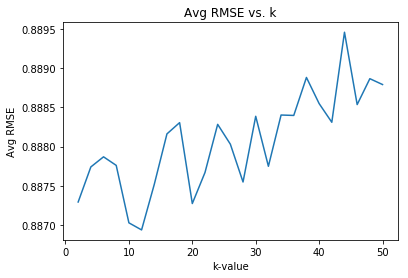

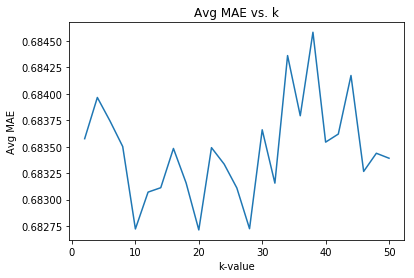

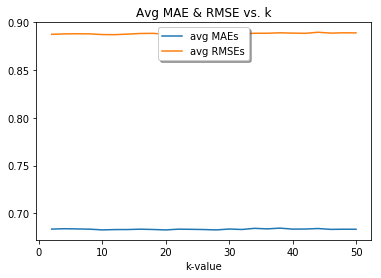

In [345]:
from surprise.prediction_algorithms.matrix_factorization import SVD

data = data_small
ks = np.linspace(2, 50, num=25)

outputs = []
for k in ks:
    algo = SVD(n_factors=int(k), biased=True)
    outputs.append(cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=10))
    
avg_rmses = []
avg_maes = []
for output in outputs:
    avg_rmses.append(np.mean(output['test_rmse']))
    avg_maes.append(np.mean(output['test_mae']))
    
plotStats(avg_rmses=avg_rmses, avg_maes=avg_maes)


# Question 25
Use the plot from question 24, to find the optimal number of latent factors. Optimal number of latent factors is the value of k that gives the minimum average RMSE or the minimum average MAE. Please report the minimum average RMSE and MAE.

In [346]:
mae_idx = np.argmin(avg_maes)
print("Best k for MAE is index: ", mae_idx, "  || best k-value: ", ks[mae_idx])

rmse_idx = np.argmin(avg_rmses)
print("Best k for RMSE is index: ", rmse_idx, " || best k-value: ", ks[rmse_idx])

print("Minimum K = %d" % max(ks[mae_idx], ks[rmse_idx])) # 16

Best k for MAE is index:  9   || best k-value:  20.0
Best k for RMSE is index:  5  || best k-value:  12.0
Minimum K = 20


# Question 26
Design a MF with bias collaborative filter to predict the ratings of the movies in the popular movie trimmed test set and evaluate it’s performance using 10-fold cross validation.Sweep k ( number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis). Also, report the minimum average RMSE

In [347]:
%%capture
data = data_small
ks = np.linspace(2, 50, num=25)
kf = KFold(n_splits=10)

avgRmses = []
for k in ks:
    algo = SVD(n_factors=int(k), biased=True)
    
    totalRMSE = 0
    totalMAE = 0
    for trainset, testset in kf.split(data):
        algo.fit(trainset)

        predictions = algo.test(popularTrim(trainset, testset))

        totalRMSE += accuracy.rmse(predictions)
        
    avgRmses.append(totalRMSE / 10.)
    



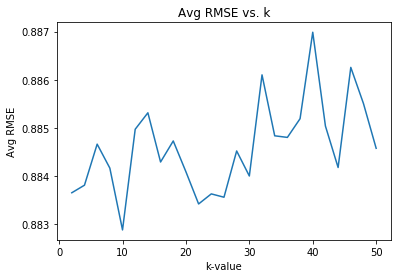

Minimum avg rmse = 0.8829


In [348]:
plotStats(avg_rmses=avgRmses)
print("Minimum avg rmse = %.4f" % np.amin(avgRmses))

# Question 27
Design a MF with bias collaborative filter to predict the ratings of the movies in the unpopular movie trimmed test set and evaluate it’s performance using 10-fold cross validation. Sweep k ( number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE ob- tained by averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis). Also, report the minimum average RMSE.

In [349]:
%%capture
data = data_small
ks = np.linspace(2, 50, num=25)
kf = KFold(n_splits=10)

avgRmses = []
for k in ks:
    algo = SVD(n_factors=int(k), biased=True)
    
    totalRMSE = 0
    totalMAE = 0
    for trainset, testset in kf.split(data):
        algo.fit(trainset)

        predictions = algo.test(unpopularTrim(trainset, testset))

        totalRMSE += accuracy.rmse(predictions)
        
    avgRmses.append(totalRMSE / 10.)

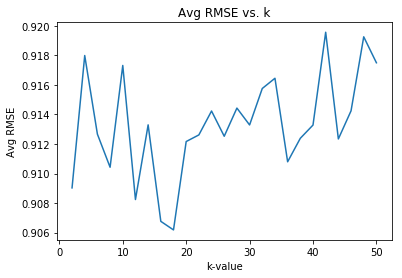

Minimum avg rmse = 0.9062


In [350]:
plotStats(avg_rmses=avgRmses)
print("Minimum avg rmse = %.4f" % np.amin(avgRmses))

# Question 28
Design a MF with bias collaborative filter to predict the ratings of the movies in the high variance movie trimmed test set and evaluate it’s performance using 10-fold cross validation.Sweep k ( number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE ob- tained by averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis). Also, report the minimum average RMSE.

In [351]:
%%capture
data = data_small
ks = np.linspace(2, 50, num=25)
kf = KFold(n_splits=10)

avgRmses = []
for k in ks:
    algo = SVD(n_factors=int(k), biased=True)
    
    totalRMSE = 0
    totalMAE = 0
    for trainset, testset in kf.split(data):
        algo.fit(trainset)

        predictions = algo.test(highVarTrim(trainset, testset))

        totalRMSE += accuracy.rmse(predictions)
        
    avgRmses.append(totalRMSE / 10.)

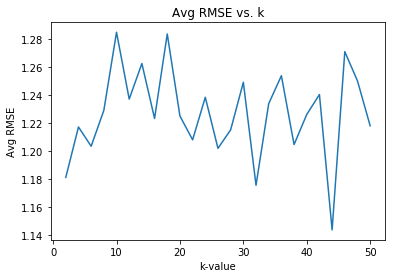

Minimum avg rmse = 1.1438


In [352]:
plotStats(avg_rmses=avgRmses)
print("Minimum avg rmse = %.4f" % np.amin(avgRmses))

# Question 29 
Plot the ROC curves for the MF with bias collaborative filter designed in question 24 for threshold values [2.5,3,3.5,4]. For the ROC plot- ting use the optimal number of latent factors found in question 25. For each of the plots, also report the area under the curve (AUC) value.

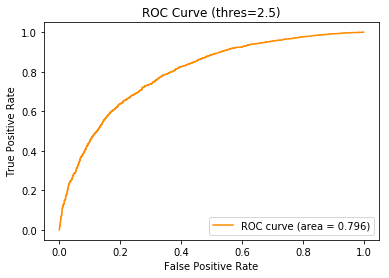

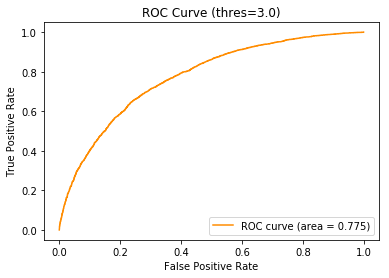

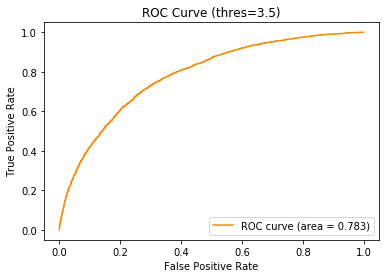

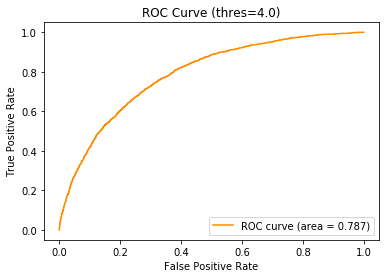

In [359]:
from sklearn import metrics
# Best k for MAE is index:  7   || best k-value:  16.0
# Best k for RMSE is index:  5  || best k-value:  12.0

data = data_small
kf = KFold(n_splits=10) # 90% for training and 10% for testing
trainset, testset = None, None
for train, test in kf.split(data): # just use the first split since we're not cross validating  (are we?)
    trainset, testset = train, test
    break
algo = SVD(n_factors=20)#KNNWithMeans(k=16, sim_options={'name': 'pearson_baseline'})
algo.fit(trainset)
pred = algo.test(testset)

for thres in [2.5, 3, 3.5, 4]:
    y_true, y_pred = [], []
    for u, i, r_real, r_pred, misc in pred:
        y_true.append(thres < r_real)
        y_pred.append(r_pred)

    fpr, tpr, _ = metrics.roc_curve(y_true=y_true, y_score=y_pred, pos_label=1)
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.3f)' % metrics.roc_auc_score(y_true=y_true, y_score=y_pred))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (thres=%.1f)' % thres)
    plt.legend(loc="lower right")
    plt.show()

    

# Question 30
Design a naive collaborative filter to predict the ratings of the movies in the MovieLens dataset and evaluate it’s performance using 10-fold cross validation. Compute the average RMSE by averaging the RMSE across all 10 folds. Report the average RMSE.

In [360]:
from surprise import AlgoBase

class NaiveFilter(AlgoBase):
    def __init__(self):
        AlgoBase.__init__(self)
        
    def estimate(self, u, i):
        #return self.mean
        mean = np.mean([r for (_, r) in self.trainset.ur[u]])
        return mean

In [361]:
data = data_small
ks = np.linspace(2, 50, num=25)

algo = NaiveFilter()
output = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=10)
    

avg_rmse = np.mean(output['test_rmse'])
avg_mae = np.mean(output['test_mae'])
    
print("Avg RMSE: ", avg_rmse)
print("Avg MAE: ", avg_mae)



Avg RMSE:  0.962542558756
Avg MAE:  0.750142210227


# Question 31
Design a naive collaborative filter to predict the ratings of the movies in the popular movie trimmed test set and evaluate it’s performance using 10-fold cross validation. Compute the average RMSE by averaging the RMSE across all 10 folds. Report the average RMSE.

In [362]:
%%capture
data = data_small
ks = np.linspace(2, 50, num=25)
kf = KFold(n_splits=10)

avgRmses = []
for k in ks:
    algo = SVD(n_factors=int(k), biased=True)
    
    totalRMSE = 0
    totalMAE = 0
    for trainset, testset in kf.split(data):
        algo.fit(trainset)

        predictions = algo.test(popularTrim(trainset, testset))

        totalRMSE += accuracy.rmse(predictions)
        
    avgRmses.append(totalRMSE / 10.)

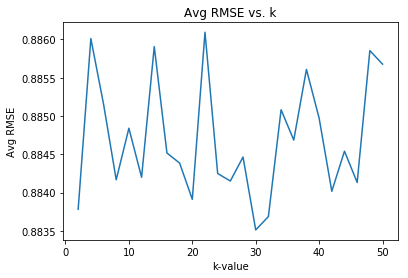

Minimum avg rmse = 0.8835


In [363]:
plotStats(avg_rmses=avgRmses)
print("Minimum avg rmse = %.4f" % np.amin(avgRmses))

# Question 32 
Design a naive collaborative filter to predict the ratings of the movies in the unpopular movie trimmed test set and evaluate it’s performance using 10-fold cross validation. Compute the average RMSE by averaging the RMSE across all 10 folds. Report the average RMSE.

In [364]:
%%capture
data = data_small
ks = np.linspace(2, 50, num=25)
kf = KFold(n_splits=10)

avgRmses = []
for k in ks:
    algo = SVD(n_factors=int(k), biased=True)
    
    totalRMSE = 0
    totalMAE = 0
    for trainset, testset in kf.split(data):
        algo.fit(trainset)

        predictions = algo.test(unpopularTrim(trainset, testset))

        totalRMSE += accuracy.rmse(predictions)
        
    avgRmses.append(totalRMSE / 10.)

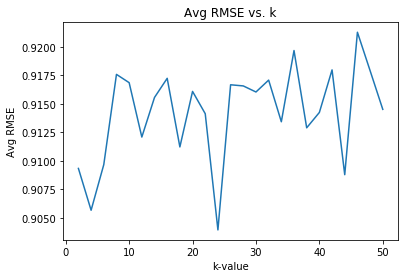

Minimum avg rmse = 0.9039


In [365]:
plotStats(avg_rmses=avgRmses)
print("Minimum avg rmse = %.4f" % np.amin(avgRmses))

# Question 33 
Design a naive collaborative filter to predict the ratings of the movies in the high variance movie trimmed test set and evaluate it’s perfor- mance using 10-fold cross validation. Compute the average RMSE by averaging the RMSE across all 10 folds. Report the average RMSE.

In [366]:
%%capture
data = data_small
ks = np.linspace(2, 50, num=25)
kf = KFold(n_splits=10)

avgRmses = []
for k in ks:
    algo = SVD(n_factors=int(k), biased=True)
    
    totalRMSE = 0
    totalMAE = 0
    for trainset, testset in kf.split(data):
        algo.fit(trainset)

        predictions = algo.test(highVarTrim(trainset, testset))

        totalRMSE += accuracy.rmse(predictions)
        
    avgRmses.append(totalRMSE / 10.)

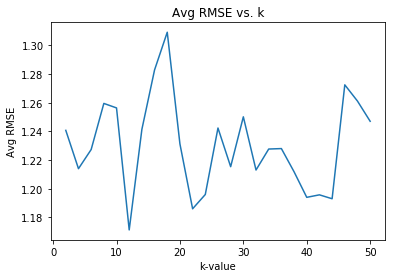

Minimum avg rmse = 1.1713


In [367]:
plotStats(avg_rmses=avgRmses)
print("Minimum avg rmse = %.4f" % np.amin(avgRmses))

# Question 34
Plot the ROC curves (threshold = 3) for the k-NN, NNMF, and
MF with bias based collaborative filters in the same figure. Use the figure to
compare the performance of the filters in predicting the ratings of the movies.

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


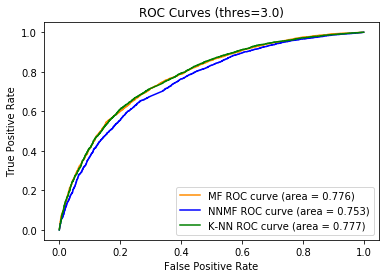

In [25]:
from sklearn import metrics
from surprise import KNNBasic, KNNWithMeans, NMF, SVD
from surprise import accuracy
from surprise.model_selection import KFold

thres = 3

data = data_small
kf = KFold(n_splits=10) # 90% for training and 10% for testing
trainset, testset = None, None
for train, test in kf.split(data): # just use the first split since we're not cross validating  (are we?)
    trainset, testset = train, test
    break
    
algo = SVD(n_factors=20)
algo.fit(trainset)
pred = algo.test(testset)

y_true, y_pred = [], []
for u, i, r_real, r_pred, misc in pred:
    y_true.append(thres < r_real)
    y_pred.append(r_pred)

fpr, tpr, _ = metrics.roc_curve(y_true=y_true, y_score=y_pred, pos_label=1)
plt.plot(fpr, tpr, color='darkorange', label='MF ROC curve (area = %0.3f)' % metrics.roc_auc_score(y_true=y_true, y_score=y_pred))

algo = NMF(n_factors=18)
algo.fit(trainset)
pred = algo.test(testset)

y_true, y_pred = [], []
for u, i, r_real, r_pred, misc in pred:
    y_true.append(thres < r_real)
    y_pred.append(r_pred)

fpr, tpr, _ = metrics.roc_curve(y_true=y_true, y_score=y_pred, pos_label=1)
plt.plot(fpr, tpr, color='blue', label='NNMF ROC curve (area = %0.3f)' % metrics.roc_auc_score(y_true=y_true, y_score=y_pred))

algo = KNNWithMeans(k=14, sim_options={'name': 'pearson_baseline'})
algo.fit(trainset)
pred = algo.test(testset)

y_true, y_pred = [], []
for u, i, r_real, r_pred, misc in pred:
    y_true.append(thres < r_real)
    y_pred.append(r_pred)

fpr, tpr, _ = metrics.roc_curve(y_true=y_true, y_score=y_pred, pos_label=1)
plt.plot(fpr, tpr, color='green', label='K-NN ROC curve (area = %0.3f)' % metrics.roc_auc_score(y_true=y_true, y_score=y_pred))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (thres=%.1f)' % thres)
plt.legend(loc="lower right")

plt.show()

# Question 35
<i>Precision and Recall are defined by the mathematical expressions
given by equations 12 and 13 respectively. Please explain the meaning of
precision and recall in your own words.</i>

Precision is defined as the ratio between the number of correctly recommended items (because the we know the ground truth that the user has liked this item), and the total number of recommneded items. This metric measures how efficient our recommendations are as ideally, we want to only recommend liked items over all our recommendations i.e. keeping the number of recommendations as low as possible.

On the other hand, recall is the ratio between the same number of correctly recommended items, and the total number of ground truth items that the user has liked previously. This metric promotes the full coverage of the total ground truth items, as we no longer care how efficient our recommendations are but instead focus on recommending as many ground truth items as possible.

# Question 36
<i>Plot average precision (Y-axis) against t (X-axis) for the ranking
obtained using k-NN collaborative filter predictions. Also, plot the average
recall (Y-axis) against t (X-axis) and average precision (Y-axis) against average
recall (X-axis). Use the k found in question 11 and sweep t from 1 to 25 in step
sizes of 1. For each plot, briefly comment on the shape of the plot.</i>

In [26]:
%%capture

from collections import defaultdict

def precision_recall_at_k(predictions, k=10, threshold=3.5):
    '''Return precision and recall at k metrics for each user.'''
    badUsers = 0
    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        # If some user in the test set has rated less than t items, then drop this user
        if len(user_ratings) < k:
            badUsers += 1
            continue
    
        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        # If |G| = 0 for some user in the test set, then drop this user 
        if n_rel is 0:
            badUsers += 1
            continue

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1
    
    print("Filtered out %d" % badUsers)
    return precisions, recalls

ts = np.linspace(1, 25, num=25)
thres = 3
data = data_small
kf = KFold(n_splits=10)

avgPrecisions, avgRecalls = [], []
for t in ts:
    algo = KNNWithMeans(k=14, sim_options={'name': 'pearson_baseline'})
    
    totalPrecisions, totalRecalls = 0.0, 0.0    
    for trainset, testset in kf.split(data):
        algo.fit(trainset)

        pred = algo.test(testset) 

        precisions, recalls = precision_recall_at_k(pred, k=int(t), threshold=thres)
        totalPrecisions += np.mean(list(precisions.values()))
        totalRecalls += np.mean(list(recalls.values()))
        
    avgPrecisions.append(totalPrecisions / 10.)
    avgRecalls.append(totalRecalls / 10.)
    


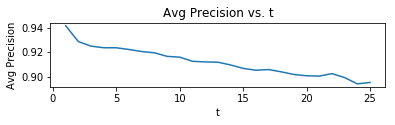

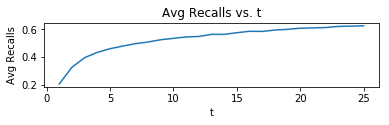

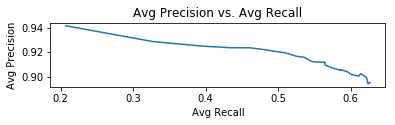

In [17]:
#ax = plt.subplot(111)
width = 2

plt.subplot(3,1,1)
plt.title("Avg Precision vs. t")
plt.ylabel("Avg Precision")
plt.xlabel("t")
plt.plot(ts, avgPrecisions)
plt.show()

plt.subplot(3,1,2)
plt.title("Avg Recalls vs. t")
plt.ylabel("Avg Recalls")
plt.xlabel("t")
plt.plot(ts, avgRecalls)
plt.show()

plt.subplot(3,1,3)
plt.title("Avg Precision vs. Avg Recall")
plt.ylabel("Avg Precision")
plt.xlabel("Avg Recall")
plt.plot(avgRecalls, avgPrecisions)
plt.show()

# Question 37
Plot average precision (Y-axis) against t (X-axis) for the ranking
obtained using NNMF-based collaborative filter predictions. Also, plot the
average recall (Y-axis) against t (X-axis) and average precision (Y-axis) against
average recall (X-axis). Use optimal number of latent factors found in question
18 and sweep t from 1 to 25 in step sizes of 1. For each plot, briefly comment
on the shape of the plot.

In [22]:
%%capture
ts = np.linspace(1, 25, num=25)
thres = 3
data = data_small
kf = KFold(n_splits=10)

avgPrecisions, avgRecalls = [], []
for t in ts:
    algo = NMF(n_factors=18)
    
    totalPrecisions, totalRecalls = 0.0, 0.0    
    for trainset, testset in kf.split(data):
        algo.fit(trainset)

        pred = algo.test(testset) 

        precisions, recalls = precision_recall_at_k(pred, k=int(t), threshold=thres)
        totalPrecisions += np.mean(list(precisions.values()))
        totalRecalls += np.mean(list(recalls.values()))
        
    avgPrecisions.append(totalPrecisions / 10.)
    avgRecalls.append(totalRecalls / 10.)
    


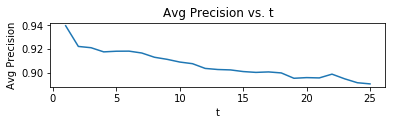

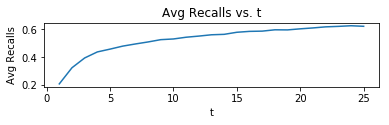

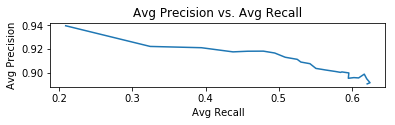

In [23]:
width = 2

plt.subplot(3,1,1)
plt.title("Avg Precision vs. t")
plt.ylabel("Avg Precision")
plt.xlabel("t")
plt.plot(ts, avgPrecisions)
plt.show()

plt.subplot(3,1,2)
plt.title("Avg Recalls vs. t")
plt.ylabel("Avg Recalls")
plt.xlabel("t")
plt.plot(ts, avgRecalls)
plt.show()

plt.subplot(3,1,3)
plt.title("Avg Precision vs. Avg Recall")
plt.ylabel("Avg Precision")
plt.xlabel("Avg Recall")
plt.plot(avgRecalls, avgPrecisions)
plt.show()

# Question 38
Plot average precision (Y-axis) against t (X-axis) for the ranking
obtained using MF with bias-based collaborative filter predictions. Also, plot
the average recall (Y-axis) against t (X-axis) and average precision (Y-axis)
against average recall (X-axis). Use optimal number of latent factors found in
question 25 and sweep t from 1 to 25 in step sizes of 1. For each plot, briefly
comment on the shape of the plot.

In [29]:
%%capture
ts = np.linspace(1, 25, num=25)
thres = 3
data = data_small
kf = KFold(n_splits=10)

avgPrecisions, avgRecalls = [], []
for t in ts:
    algo = SVD(n_factors=20)
    
    totalPrecisions, totalRecalls = 0.0, 0.0    
    for trainset, testset in kf.split(data):
        algo.fit(trainset)

        pred = algo.test(testset) 

        precisions, recalls = precision_recall_at_k(pred, k=int(t), threshold=thres)
        totalPrecisions += np.mean(list(precisions.values()))
        totalRecalls += np.mean(list(recalls.values()))
        
    avgPrecisions.append(totalPrecisions / 10.)
    avgRecalls.append(totalRecalls / 10.)
    


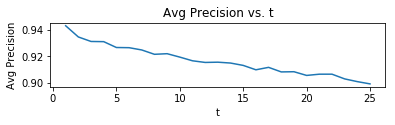

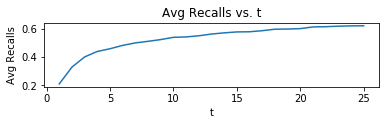

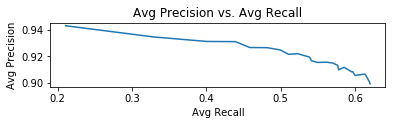

In [30]:
width = 2

plt.subplot(3,1,1)
plt.title("Avg Precision vs. t")
plt.ylabel("Avg Precision")
plt.xlabel("t")
plt.plot(ts, avgPrecisions)
plt.show()

plt.subplot(3,1,2)
plt.title("Avg Recalls vs. t")
plt.ylabel("Avg Recalls")
plt.xlabel("t")
plt.plot(ts, avgRecalls)
plt.show()

plt.subplot(3,1,3)
plt.title("Avg Precision vs. Avg Recall")
plt.ylabel("Avg Precision")
plt.xlabel("Avg Recall")
plt.plot(avgRecalls, avgPrecisions)
plt.show()

# Question 39
Plot the precision-recall curve obtained in questions 36,37, and
38 in the same figure. Use this figure to compare the relevance of the recommendation
list generated using k-NN, NNMF, and MF with bias predictions.

In [31]:
def getUR(testset):
    o = {}
    for u, i, r in testset:
        if int(i) in o:
            o[int(u)].append((int(i), r))
        else:
            o[int(u)] = [(int(i), r)]
    return o

def buildItemVar(trainset, testsetir):
    o = {}
    for k, v in trainset.ir.items():
        o[k] = [r for u, r in v]
    for k, v in testsetir.items():
        if k in o:
            for u, r in v:
                o[k].append(r)
        else:
            o[k] = [r for u, r in v]
    return o

def filterTestset(trainset, testset, threshold=3):
    testsetur = getUR(testset)
    blacklist = {}
    for k, v in testsetur.items():
        n_rel = sum((true_r >= threshold) for _, true_r in v)
        if n_rel == 0: # G == 0
            blacklist[k] = True
    
    
    

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


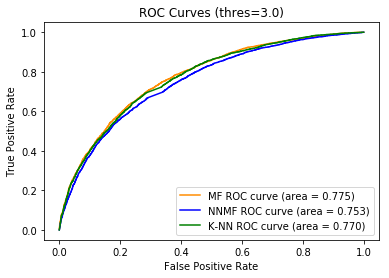

In [32]:
from sklearn import metrics
from surprise import KNNBasic, KNNWithMeans, NMF, SVD
from surprise import accuracy
from surprise.model_selection import KFold

thres = 3

data = data_small
kf = KFold(n_splits=10) # 90% for training and 10% for testing
trainset, testset = None, None
for train, test in kf.split(data): # just use the first split since we're not cross validating  (are we?)
    trainset, testset = train, test
    break
    
algo = SVD(n_factors=20)
algo.fit(trainset)
pred = algo.test(testset)

y_true, y_pred = [], []
for u, i, r_real, r_pred, misc in pred:
    y_true.append(thres < r_real)
    y_pred.append(r_pred)

fpr, tpr, _ = metrics.roc_curve(y_true=y_true, y_score=y_pred, pos_label=1)
plt.plot(fpr, tpr, color='darkorange', label='MF ROC curve (area = %0.3f)' % metrics.roc_auc_score(y_true=y_true, y_score=y_pred))

algo = NMF(n_factors=18)
algo.fit(trainset)
pred = algo.test(testset)

y_true, y_pred = [], []
for u, i, r_real, r_pred, misc in pred:
    y_true.append(thres < r_real)
    y_pred.append(r_pred)

fpr, tpr, _ = metrics.roc_curve(y_true=y_true, y_score=y_pred, pos_label=1)
plt.plot(fpr, tpr, color='blue', label='NNMF ROC curve (area = %0.3f)' % metrics.roc_auc_score(y_true=y_true, y_score=y_pred))

algo = KNNWithMeans(k=14, sim_options={'name': 'pearson_baseline'})
algo.fit(trainset)
pred = algo.test(testset)

y_true, y_pred = [], []
for u, i, r_real, r_pred, misc in pred:
    y_true.append(thres < r_real)
    y_pred.append(r_pred)

fpr, tpr, _ = metrics.roc_curve(y_true=y_true, y_score=y_pred, pos_label=1)
plt.plot(fpr, tpr, color='green', label='K-NN ROC curve (area = %0.3f)' % metrics.roc_auc_score(y_true=y_true, y_score=y_pred))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (thres=%.1f)' % thres)
plt.legend(loc="lower right")

plt.show()